<a href="https://colab.research.google.com/github/IKEDAKAZUKI/Qiskit-Tutorial/blob/main/Quantum_computation_of_n_point_correpation_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kazuki Ikeda's note book (see [Website](https://kazukiikeda.studio.site/) or [Github](https://github.com/IKEDAKAZUKI) for more tutorials and research)

This note provides a Qiskit tutorial on Hadamard test and quantum simulation of two-point function $\langle\psi|O(t,x)O(t_0,x_0)|\psi\rangle$, which will be useful to study scattering processes or particle correlations in high-energy, nuclear, or condensed matter physics by means of a quantum computer.

We use the Schwinger model (2d Quantum Electrodynamics (QED)) as a benchmark model.

In [3]:
pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 14.7 MB/s eta 0:00:00


In [4]:
pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.0 MB/s eta 0:00:00


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import * #qiskit
from qiskit_aer.aerprovider import AerSimulator
#from qiskit.extensions import Initialize
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.quantum_info import random_statevector
from qiskit.quantum_info import partial_trace, entropy
import qiskit.quantum_info as qi
#from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import random_unitary
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex


# Hadamard test

We first prepare a state $|0\rangle\otimes|\psi\rangle=|0\rangle\otimes U|0\rangle$, using a random unitary matrix $U$.

In [ ]:
qr = QuantumRegister(2)
cr = ClassicalRegister(1)

qc = QuantumCircuit(qr, cr)

qc.append(random_unitary(2), [1])
qc.draw()

q59_0: ───────────
       ┌─────────┐
q59_1: ┤ Unitary ├
       └─────────┘
c19: 1/═══════════

The following circuit is called an Hadamard test. It calculates $\langle Z_0\rangle=Re\langle\psi|V|\psi\rangle$, where $V$ is another random unitary matrix.  

In [ ]:
qc.h([0])

qc1 = QuantumCircuit(1)
qc1.append(random_unitary(2), [0])
V = qc1.to_gate().control(1)

qc.append(V, [0, 1])
qc.h([0])
qc.measure(0,0)
qc.draw()

┌───┐                  ┌───┐┌─┐
q59_0: ───┤ H ├──────────■───────┤ H ├┤M├
       ┌──┴───┴──┐┌──────┴──────┐└───┘└╥┘
q59_1: ┤ Unitary ├┤ circuit-502 ├──────╫─
       └─────────┘└─────────────┘      ║ 
c19: 1/════════════════════════════════╩═
                                       0

{'0': 60, '1': 940}


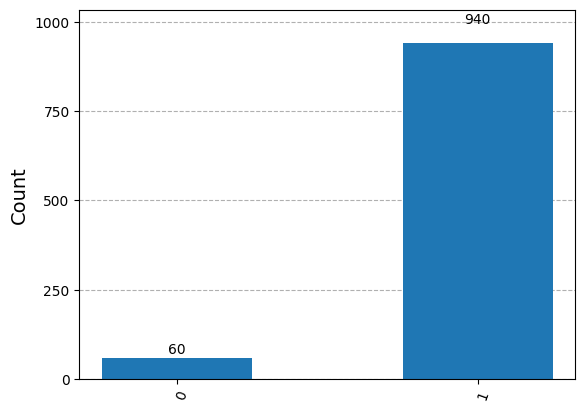

In [ ]:
simulator=AerSimulator()
n_shots=1000
qc_total = transpile(qc, simulator)

job = simulator.run(qc_total, backend=simulator, shots=n_shots)
job.status()

results = job.result()
counts = results.get_counts(qc_total)
print(counts)
plot_histogram(counts)

To calculate the imaginary part, $\langle Z_0\rangle=Im\langle\psi|V|\psi\rangle$, we change the circuit as follows:

In [ ]:
qr = QuantumRegister(2)
cr = ClassicalRegister(1)

qc = QuantumCircuit(qr, cr)

qc.append(random_unitary(2), [1])

qc.h([0])
qc.sdg([0])

qc1 = QuantumCircuit(1)
qc1.append(random_unitary(2), [0])
V = qc1.to_gate().control(1)

qc.append(V, [0, 1])
qc.h([0])
qc.measure(0,0)
qc.draw()

┌───┐   ┌─────┐               ┌───┐┌─┐
q66_0: ───┤ H ├───┤ Sdg ├───────■───────┤ H ├┤M├
       ┌──┴───┴──┐└─────┘┌──────┴──────┐└───┘└╥┘
q66_1: ┤ Unitary ├───────┤ circuit-512 ├──────╫─
       └─────────┘       └─────────────┘      ║ 
c20: 1/═══════════════════════════════════════╩═
                                              0

{'1': 528, '0': 472}


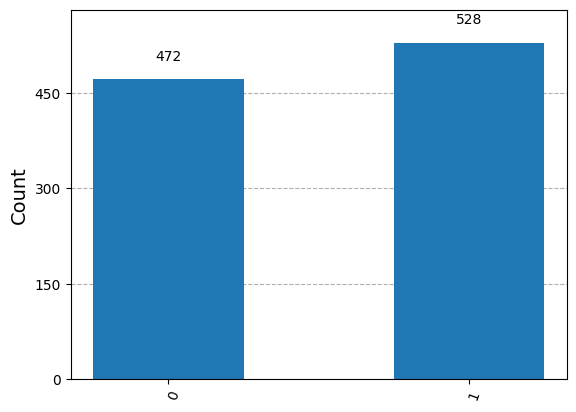

In [ ]:
simulator=AerSimulator()
n_shots=1000
qc_total = transpile(qc, simulator)

job = simulator.run(qc_total, backend=simulator, shots=n_shots)
job.status()


results = job.result()
counts = results.get_counts(qc_total)
print(counts)
plot_histogram(counts)

# Two point correlation function

First, suppose we have the following state:
$$\frac{1}{\sqrt{2}}\left(|0\rangle\otimes WU|\psi\rangle+|1\rangle\otimes UV|\psi\rangle\right)$$


By measuring the first qubit in the $X$-basis, we obtain the following expectation value:
\begin{align}
\frac{1}{2}\left(\langle\psi| U^\dagger WUV|\psi\rangle+\langle\psi| [U^\dagger WUV]^\dagger|\psi\rangle\right)&=Re\langle\psi| U^\dagger WUV|\psi\rangle\\
&=Re\langle\psi| W(t)V|\psi\rangle
\end{align}

We next compute the following two point function
$$C(t,x,x_0)=\langle\psi|O(t,x)O(t_0,x_0)|\psi\rangle,$$ where $O$ is a hermitian operator such as electric current, axial current, charge, energy, etc...

The time evolution of $O$ is given by the Heisenberg picture $$O(t,x)=U^\dagger(t)O(t_0,x)U(t),$$ where $$U(t)=\exp\left(-i\int_{t_0}^t H(\tau)d\tau\right)$$

and $H$ is a given Hamiltonian, which is Schwinger model in our case.

In the $(1+1)$ dimensional model, the local vector $Q_n$ and axial charge $Q_{5,n}$ densities are defined as follows:
\begin{align}
Q_n&=\bar{\psi}\gamma^0\psi=\frac{Z_n+(-1)^{n}}{2a}\\
Q_{5,n}&=\bar{\psi}\gamma^{5}\gamma^0\psi=\frac{X_nY_{n+1}-Y_nX_{n+1}}{4a},
\end{align}
where $a$ is a finite lattice spacing parameter. See eqs.(9) and (10) in [the paper](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.108.074001) for the details.

Let us use the Neel state $|0101\rangle$ as an initial state $|\psi\rangle$, which approximates the ground state when mass is large. As an example, we compute $$\langle 0101|Q_4(t)Q_1|0101\rangle=\frac{\langle 0101|Z_4(t)Z_1|0101\rangle-\langle 0101|Z_4(t)|0101\rangle-\langle 0101|Z_1|0101\rangle+1}{4a^2}$$

See [link](https://colab.research.google.com/drive/1Npm7YAqfJKNJuBsJrhR3habiAdl2KWfe?authuser=1#scrollTo=Tk8g_C2-bSbB&line=1&uniqifier=1) to implement the ground state of the massive Schwinger model.

For example, $Re\langle Z_4(t)Z_1\rangle$ can be computed by the following circuit:

In [234]:
n_site = 4
a = 1
M=1
g=1

J = 0.5*g*g*a

t_max = 2
step_max = 20*t_max

dt = t_max/step_max


time_list=[]
cc_list=[]
error_list=[]

p=1
q=4


job_counter=0
n_shots = 100000

### simulator and shots
simulator=AerSimulator()

job_counter=0


for step1 in range(step_max+1):

  qr = QuantumRegister(n_site+1)
  cr = ClassicalRegister(1)

  ### make main quantum circuit
  qc = QuantumCircuit(qr,cr)

  ## prepare the initial state
  for i in range(1,int(n_site/2)+1):
    qc.x(qr[2*i])


  ##Computation of the two point function

  qc.h([0])
  qc.cz([0],[p])
  for step in range(0,step1):


    for i in range(1,n_site):
        qc.cx(qr[i],qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i],qr[i+1])

        qc.rz(0.5*(0.5/a)*dt, qr[i])
        qc.rz(-0.5*(0.5/a)*dt, qr[i+1])

        qc.cx(qr[i],qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i],qr[i+1])

    ###exp(-iH_{Z}\Delta t)   mass
    for i in range(1,n_site+1):
        qc.rz(M*((-1)**(i))*dt,qr[i])


    ###exp(-iH_{ZZ}\Delta t)  Electric Field
    for i in range(2,n_site):
        for k in range(1,i+1):
            for l in range(k+1,i+1):
                qc.rzz(J*dt,qr[k],qr[l])


        ###exp(-iH_{Z}\Delta t)  Electric Field
    for n in range(1,n_site):
        qc.rz(-0.5*J*dt*(n_site-(n)-0.5*(-1+(-1)**(n))),qr[n])

    for i in range(1,n_site):
        qc.cx(qr[i],qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i],qr[i+1])

        qc.rz(0.5*(0.5/a)*dt, qr[i])
        qc.rz(-0.5*(0.5/a)*dt, qr[i+1])

        qc.cx(qr[i],qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i],qr[i+1])



  qc.x(qr[0])
  qc.cz(qr[0],qr[q])
  qc.x(qr[0])


  qc.h(qr[0])

  qc.measure(0,0)
  qc_total0 = transpile(qc, simulator)


  #execute circuit
  new_circuit = transpile(qc_total0, simulator)
  job = simulator.run(new_circuit,shots=n_shots)

  job_counter+=1

  print(100*job_counter/step_max,"% has been done")


  results = job.result()
  counts = results.get_counts(qc_total0)

  #compute chiral condensate
  value = 0
  for bit_string, count in counts.items():

      value += (-1)**int(bit_string[0])*count/n_shots



  time_list.append(dt*step1) #append time to the list of time
  cc_list.append(value)

2.5 % has been done
5.0 % has been done
7.5 % has been done
10.0 % has been done
12.5 % has been done
15.0 % has been done
17.5 % has been done
20.0 % has been done
22.5 % has been done
25.0 % has been done
27.5 % has been done
30.0 % has been done
32.5 % has been done
35.0 % has been done
37.5 % has been done
40.0 % has been done
42.5 % has been done
45.0 % has been done
47.5 % has been done
50.0 % has been done
52.5 % has been done
55.0 % has been done
57.5 % has been done
60.0 % has been done
62.5 % has been done
65.0 % has been done
67.5 % has been done
70.0 % has been done
72.5 % has been done
75.0 % has been done
77.5 % has been done
80.0 % has been done
82.5 % has been done
85.0 % has been done
87.5 % has been done
90.0 % has been done
92.5 % has been done
95.0 % has been done
97.5 % has been done
100.0 % has been done
102.5 % has been done


In [249]:
#Data by exact computation

data_x=[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35000000000000003,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41000000000000003,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47000000000000003,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.5700000000000001,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.6900000000000001,
 0.7000000000000001,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.8200000000000001,
 0.8300000000000001,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.9400000000000001,
 0.9500000000000001,
 0.96,
 0.97,
 0.98,
 0.99,
 1.0,
 1.01,
 1.02,
 1.03,
 1.04,
 1.05,
 1.06,
 1.07,
 1.08,
 1.09,
 1.1,
 1.11,
 1.12,
 1.1300000000000001,
 1.1400000000000001,
 1.1500000000000001,
 1.16,
 1.17,
 1.18,
 1.19,
 1.2,
 1.21,
 1.22,
 1.23,
 1.24,
 1.25,
 1.26,
 1.27,
 1.28,
 1.29,
 1.3,
 1.31,
 1.32,
 1.33,
 1.34,
 1.35,
 1.36,
 1.37,
 1.3800000000000001,
 1.3900000000000001,
 1.4000000000000001,
 1.41,
 1.42,
 1.43,
 1.44,
 1.45,
 1.46,
 1.47,
 1.48,
 1.49,
 1.5,
 1.51,
 1.52,
 1.53,
 1.54,
 1.55,
 1.56,
 1.57,
 1.58,
 1.59,
 1.6,
 1.61,
 1.62,
 1.6300000000000001,
 1.6400000000000001,
 1.6500000000000001,
 1.6600000000000001,
 1.67,
 1.68,
 1.69,
 1.7,
 1.71,
 1.72,
 1.73,
 1.74,
 1.75,
 1.76,
 1.77,
 1.78,
 1.79,
 1.8,
 1.81,
 1.82,
 1.83,
 1.84,
 1.85,
 1.86,
 1.87,
 1.8800000000000001,
 1.8900000000000001,
 1.9000000000000001,
 1.9100000000000001,
 1.92,
 1.93,
 1.94,
 1.95,
 1.96,
 1.97,
 1.98,
 1.99]

data_y=[-0.9999257542937603,
 -0.9997776810566182,
 -0.9995310280555272,
 -0.9991859987623963,
 -0.9987428777993806,
 -0.9982020307006024,
 -0.9975639036061362,
 -0.9968290228885138,
 -0.9959979947120587,
 -0.9950715045254239,
 -0.9940503164877552,
 -0.9929352728289627,
 -0.9917272931446348,
 -0.9904273736261872,
 -0.9890365862268911,
 -0.987556077764483,
 -0.9859870689611051,
 -0.9843308534213825,
 -0.9825887965494984,
 -0.9807623344061712,
 -0.9788529725064968,
 -0.9768622845596655,
 -0.974791911151611,
 -0.9726435583716974,
 -0.970418996384606,
 -0.9681200579486123,
 -0.9657486368815085,
 -0.9633066864754587,
 -0.9607962178621222,
 -0.9582192983294222,
 -0.9555780495913785,
 -0.9528746460124601,
 -0.9501113127879616,
 -0.9472903240819301,
 -0.9444140011242202,
 -0.9414847102682831,
 -0.938504861011328,
 -0.9354769039785324,
 -0.9324033288730029,
 -0.9292866623932228,
 -0.9261294661197452,
 -0.9229343343729302,
 -0.9197038920435252,
 -0.9164407923979422,
 -0.9131477148600862,
 -0.9098273627716108,
 -0.9064824611325133,
 -0.9031157543239767,
 -0.8997300038153978,
 -0.8963279858575501,
 -0.892912489163838,
 -0.8894863125816174,
 -0.8860522627555634,
 -0.8826131517850724,
 -0.879171794877691,
 -0.8757310080005751,
 -0.8722936055319738,
 -0.8688623979147427,
 -0.8654401893138866,
 -0.8620297752801249,
 -0.8586339404214789,
 -0.855255456084859,
 -0.8518970780496359,
 -0.8485615442351601,
 -0.845251572424188,
 -0.8419698580041557,
 -0.8387190717282279,
 -0.8355018574980368,
 -0.8323208301699982,
 -0.8291785733870783,
 -0.8260776374378631,
 -0.823020537144757,
 -0.8200097497831058,
 -0.8170477130330289,
 -0.8141368229656973,
 -0.811279432065777,
 -0.808477847291722,
 -0.8057343281755682,
 -0.803051084963841,
 -0.8004302768011635,
 -0.7978740099580998,
 -0.7953843361047424,
 -0.792963250631506,
 -0.7906126910185465,
 -0.7883345352551853,
 -0.786130600310674,
 -0.7840026406575858,
 -0.7819523468490767,
 -0.7799813441512078,
 -0.7780911912314796,
 -0.7762833789046646,
 -0.7745593289369888,
 -0.7729203929096521,
 -0.7713678511426254,
 -0.7699029116796102,
 -0.7685267093349912,
 -0.7672403048035585,
 -0.7660446838337164,
 -0.7649407564648438,
 -0.7639293563294095,
 -0.7630112400203932,
 -0.7621870865244955,
 -0.7614574967215767,
 -0.7608229929506852,
 -0.7602840186429973,
 -0.7598409380219163,
 -0.7594940358705218,
 -0.7592435173665096,
 -0.7590895079846841,
 -0.7590320534670265,
 -0.7590711198602856,
 -0.7592065936209866,
 -0.7594382817876875,
 -0.7597659122202629,
 -0.7601891339059236,
 -0.760707517331634,
 -0.7613205549225152,
 -0.7620276615457846,
 -0.7628281750797028,
 -0.7637213570469598,
 -0.7647063933118661,
 -0.7657823948406592,
 -0.7669483985241898,
 -0.7682033680621816,
 -0.7695461949082241,
 -0.7709756992745922,
 -0.7724906311959389,
 -0.7740896716508563,
 -0.7757714337402557,
 -0.7775344639214579,
 -0.7793772432968517,
 -0.781298188955921,
 -0.7832956553694013,
 -0.7853679358342813,
 -0.7875132639683274,
 -0.789729815252757,
 -0.7920157086216606,
 -0.7943690080967261,
 -0.7967877244657782,
 -0.7992698170036275,
 -0.8018131952336646,
 -0.8044157207286265,
 -0.8070752089489175,
 -0.8097894311168414,
 -0.8125561161250736,
 -0.8153729524776807,
 -0.8182375902619592,
 -0.8211476431493576,
 -0.8241006904237101,
 -0.8270942790350047,
 -0.8301259256768763,
 -0.8331931188860139,
 -0.8362933211616463,
 -0.8394239711032618,
 -0.842582485564708,
 -0.8457662618228058,
 -0.848972679758606,
 -0.8521991040494139,
 -0.8554428863696917,
 -0.8587013675989673,
 -0.8619718800348539,
 -0.8652517496093031,
 -0.8685382981062094,
 -0.8718288453784904,
 -0.8751207115627703,
 -0.8784112192898087,
 -0.8816976958888192,
 -0.8849774755838345,
 -0.8882479016802907,
 -0.8915063287400167,
 -0.894750124742824,
 -0.8979766732329217,
 -0.9011833754483837,
 -0.9043676524319325,
 -0.9075269471213134,
 -0.9106587264175587,
 -0.9137604832294695,
 -0.9168297384926622,
 -0.9198640431615621,
 -0.9228609801727425,
 -0.925818166378052,
 -0.9287332544459892,
 -0.9316039347298273,
 -0.9344279371010147,
 -0.9372030327464193,
 -0.9399270359280143,
 -0.9425978057036419,
 -0.9452132476075267,
 -0.9477713152892507,
 -0.9502700121099386,
 -0.9527073926944443,
 -0.9550815644383663,
 -0.9573906889687653,
 -0.9596329835574977,
 -0.9618067224861204,
 -0.9639102383613687,
 -0.9659419233802446,
 -0.9679002305438178,
 -0.9697836748188569,
 -0.971590834246484]

Text(0, 0.5, 'Re$[\\langle Z_4(t)Z_1\\rangle]$')

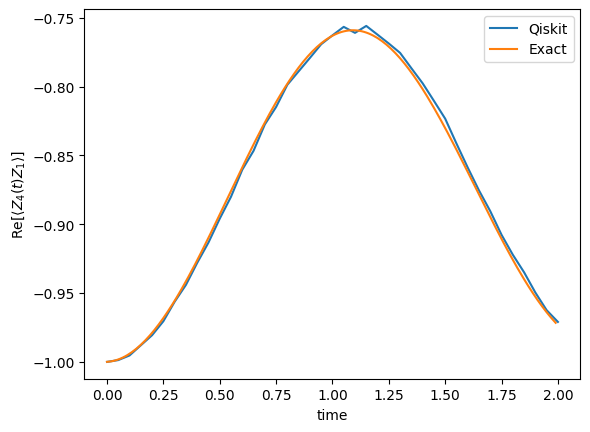

In [250]:
#Comparison between Qiskit and Exact results
plt.plot(time_list,cc_list,label="Qiskit")
plt.plot(data_x,data_y,label="Exact")
plt.legend()
plt.xlabel("time")
plt.ylabel(r"Re$[\langle Z_4(t)Z_1\rangle]$")

In [251]:
#Draw the quantum circuit

qc.draw()

┌───┐   ┌───┐                                                     »
q35316_0: ┤ H ├─■─┤ X ├─────────────────────────────────────────────────────»
          └───┘ │ └───┘┌───┐      ┌────────────┐     ┌───┐     ┌───────────┐»
q35316_1: ──────■───■──┤ H ├──■───┤ Rz(0.0125) ├──■──┤ H ├──■──┤ Rz(-0.05) ├»
          ┌───┐   ┌─┴─┐└───┘┌─┴─┐┌┴────────────┤┌─┴─┐└───┘┌─┴─┐└───────────┘»
q35316_2: ┤ X ├───┤ X ├─────┤ X ├┤ Rz(-0.0125) ├┤ X ├─────┤ X ├──────■──────»
          └───┘   └───┘     └───┘└─────────────┘└───┘     └───┘    ┌─┴─┐    »
q35316_3: ─────────────────────────────────────────────────────────┤ X ├────»
          ┌───┐                                                    └───┘    »
q35316_4: ┤ X ├─────────────────────────────────────────────────────────────»
          └───┘                                                             »
 c2173: 1/══════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                          »
«q35316_0: ────────────────────────────────────────────────────────────────»
«                                                                          »
«q35316_1: ─────────────────────────────────────────────────────■──────────»
«          ┌───┐      ┌────────────┐     ┌───┐     ┌──────────┐ │ZZ(0.025) »
«q35316_2: ┤ H ├──■───┤ Rz(0.0125) ├──■──┤ H ├──■──┤ Rz(0.05) ├─■──────────»
«          └───┘┌─┴─┐┌┴────────────┤┌─┴─┐└───┘┌─┴─┐└──────────┘   ┌───┐    »
«q35316_3: ─────┤ X ├┤ Rz(-0.0125) ├┤ X ├─────┤ X ├─────■─────────┤ H ├────»
«               └───┘└─────────────┘└───┘     └───┘   ┌─┴─┐       └───┘    »
«q35316_4: ───────────────────────────────────────────┤ X ├────────────────»
«                                                     └───┘                »
« c2173: 1/════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                             »
«q35316_0: ───────────────────────────────────────────────────────────────────»
«                                                                             »
«q35316_1: ─■──────────────────────────────────────────────────────■──────────»
«           │ZZ(0.025)                                             │          »
«q35316_2: ─■──────────────────────────────────────────────────────┼──────────»
«                       ┌────────────┐     ┌───┐     ┌───────────┐ │ZZ(0.025) »
«q35316_3: ─────■───────┤ Rz(0.0125) ├──■──┤ H ├──■──┤ Rz(-0.05) ├─■──────────»
«             ┌─┴─┐    ┌┴────────────┤┌─┴─┐└───┘┌─┴─┐└┬──────────┤            »
«q35316_4: ───┤ X ├────┤ Rz(-0.0125) ├┤ X ├─────┤ X ├─┤ Rz(0.05) ├────────────»
«             └───┘    └─────────────┘└───┘     └───┘ └──────────┘            »
« c2173: 1/═══════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                             »
«q35316_0: ───────────────────────────────────────────────────────────────────»
«          ┌───────────┐                   ┌───┐      ┌────────────┐     ┌───┐»
«q35316_1: ┤ Rz(-0.05) ├────────────────■──┤ H ├──■───┤ Rz(0.0125) ├──■──┤ H ├»
«          └───────────┘┌────────────┐┌─┴─┐└───┘┌─┴─┐┌┴────────────┤┌─┴─┐└───┘»
«q35316_2: ──■──────────┤ Rz(-0.025) ├┤ X ├─────┤ X ├┤ Rz(-0.0125) ├┤ X ├─────»
«            │ZZ(0.025) ├────────────┤└───┘     └───┘└─────────────┘└───┘     »
«q35316_3: ──■──────────┤ Rz(-0.025) ├────────────────────────────────────────»
«                       └────────────┘                                        »
«q35316_4: ───────────────────────────────────────────────────────────────────»
«                                                                             »
« c2173: 1/════════════════════════════════════════════════════════════════